In [30]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import IPython.display as ipd

import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

from sklearn.preprocessing import LabelEncoder

In [31]:
BASE_DIR = '/content/dohai90/datasets/UrbanSoundClassification'
audio_fn = os.path.join(BASE_DIR, 'Test/95.wav')
ipd.Audio(audio_fn)

In [3]:
y, sampling_rate = librosa.load(audio_fn)

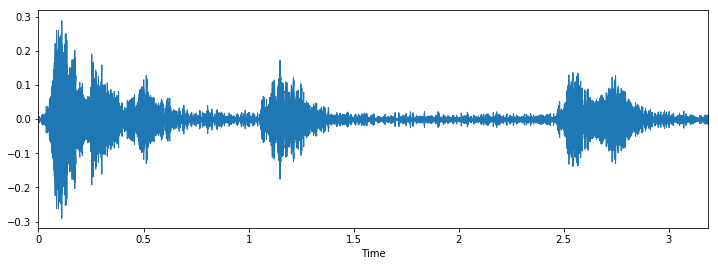

In [4]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(y, sr=sampling_rate)
plt.show()

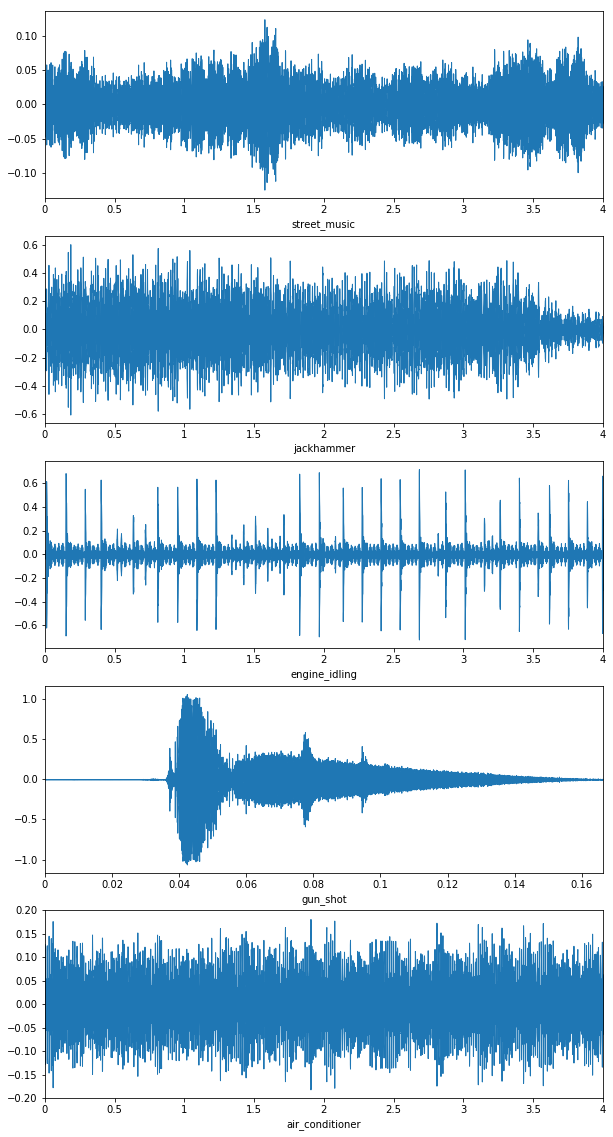

In [5]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
rows = 5
for i in range(rows):
    idx = np.random.choice(train_df.index)
    fn = os.path.join(BASE_DIR, 'Train', str(train_df.ID[idx]) + '.wav')
    y, sampling_rate = librosa.load(fn)
    plt.subplot(rows, 1, i+1)
    librosa.display.waveplot(y, sr=sampling_rate)
    plt.xlabel(train_df.Class[idx])

plt.gcf().set_size_inches(10, 20)
plt.show()

In [113]:
train_df.head(5)

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


In [6]:
train_df.Class.value_counts() / len(train_df)

jackhammer          0.122907
engine_idling       0.114811
siren               0.111684
dog_bark            0.110396
children_playing    0.110396
street_music        0.110396
drilling            0.110396
air_conditioner     0.110396
car_horn            0.056302
gun_shot            0.042318
Name: Class, dtype: float64

# Load data and extract features

In [7]:
def parser(row):    
    fn = os.path.join(BASE_DIR, 'Train', str(row.ID) + '.wav')    
    
    try:
        # kaiser_fast is a technique for fast extraction
        y, sampling_rate = librosa.load(fn, res_type='kaiser_fast')
        # extract mfcc feature from the loaded data
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sampling_rate, n_mfcc=40).T, axis=0)
    except Exception as e:
        print('Encountered error while processing file:', fn)
        return None, None
    
    feature = mfccs
    label = row.Class
    return [feature, label]

In [8]:
%%time
train_series = train_df.apply(parser, axis=1)
X = np.array([train_series.values[i][0] for i in range(len(train_series.values))])
y_lb = np.array([train_series.values[i][1] for i in range(len(train_series.values))])

CPU times: user 13min 49s, sys: 1h 3min 47s, total: 1h 17min 36s
Wall time: 9min 42s


In [116]:
train_series[0]

[array([-82.12358939, 139.50591598, -42.43086489,  24.82786139,
        -11.62076447,  23.49708426, -12.19458986,  25.89713885,
         -9.40527728,  21.21042898,  -7.36882138,  14.25433903,
         -8.67870015,   7.75023765, -10.1241154 ,   3.2581183 ,
        -11.35261914,   2.80096779,  -7.04601346,   3.91331351,
         -2.3349743 ,   2.01242254,  -2.79394367,   4.12927394,
         -1.62076864,   4.32620082,  -1.03440959,  -1.23297714,
         -3.11085341,   0.32044827,  -1.787786  ,   0.44295495,
         -1.79164752,  -0.76361758,  -1.24246428,  -0.27664012,
          0.65718559,  -0.50237115,  -2.60428533,  -1.05346291]), 'siren']

In [9]:
encoder = LabelEncoder()
encoded_lb = encoder.fit_transform(y_lb)
y = keras.preprocessing.utils.np_utils.to_categorical(encoded_lb)

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
encoder.inverse_transform(encoded_lb)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['siren', 'street_music', 'drilling', ..., 'engine_idling',
       'engine_idling', 'air_conditioner'], dtype='<U16')

# Building model

In [12]:
model = keras.Sequential()
model.add(keras.layers.Dense(256, input_dim=40, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(y.shape[1], activation='softmax'))
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

In [13]:
history = model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)

Train on 4348 samples, validate on 1087 samples
Epoch 1/5
4348/4348 [==============================] - 2s 447us/step - loss: 6.6418 - categorical_accuracy: 0.2562 - val_loss: 2.0248 - val_categorical_accuracy: 0.2935
Epoch 2/5
4348/4348 [==============================] - 1s 145us/step - loss: 1.9719 - categorical_accuracy: 0.3480 - val_loss: 1.6348 - val_categorical_accuracy: 0.4618
Epoch 3/5
4348/4348 [==============================] - 1s 163us/step - loss: 1.6814 - categorical_accuracy: 0.4381 - val_loss: 1.4089 - val_categorical_accuracy: 0.5078
Epoch 4/5
4348/4348 [==============================] - 1s 155us/step - loss: 1.4702 - categorical_accuracy: 0.4977 - val_loss: 1.2503 - val_categorical_accuracy: 0.5833
Epoch 5/5
4348/4348 [==============================] - 1s 144us/step - loss: 1.3023 - categorical_accuracy: 0.5630 - val_loss: 1.0827 - val_categorical_accuracy: 0.6412


In [122]:
_, acc = model.evaluate(X, y)
acc

5435/5435 [==============================] - 0s 46us/step


0.6756209752158276

In [105]:
rd_idx = np.random.choice(len(X))
test_fn = os.path.join(BASE_DIR, 'Train', str(train_df.ID[rd_idx]) + '.wav')

In [106]:
x_test = X[rd_idx]
preds = model.predict(x_test[np.newaxis, :])
lb_idx = np.argmax(preds)
lb = encoder.inverse_transform(lb_idx)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [107]:
ipd.Audio(test_fn)

In [108]:
print('I think I hear {} sound, but actually, it is {} sound'.format(lb, train_df.Class[rd_idx]))

I think I hear jackhammer sound, but actually, it is jackhammer sound


array([-82.12358939, 139.50591598, -42.43086489,  24.82786139,
       -11.62076447,  23.49708426, -12.19458986,  25.89713885,
        -9.40527728,  21.21042898,  -7.36882138,  14.25433903,
        -8.67870015,   7.75023765, -10.1241154 ,   3.2581183 ,
       -11.35261914,   2.80096779,  -7.04601346,   3.91331351,
        -2.3349743 ,   2.01242254,  -2.79394367,   4.12927394,
        -1.62076864,   4.32620082,  -1.03440959,  -1.23297714,
        -3.11085341,   0.32044827,  -1.787786  ,   0.44295495,
        -1.79164752,  -0.76361758,  -1.24246428,  -0.27664012,
         0.65718559,  -0.50237115,  -2.60428533,  -1.05346291])